In [1]:
from database.pymysql_conn import DataBase
from util.text import clean_text

import pandas as pd
import numpy as np
import re
import nltk
import pickle

from collections import Counter
from pathlib import Path
from nltk.corpus import stopwords
from scipy.stats import entropy
from matplotlib import pyplot as plt

from typing import Dict

# Data Load

In [2]:
db = DataBase()

In [3]:
path = Path('cached')

DB 에서 가져오려면 `from DB` 실행

쿼리가 오래 걸리므로 pickle로 저장해두고 사용할때는 `to pkl` 로 저장하고, `from pkl`로 불러와 사용

## from DB

In [ ]:
# df_success = db.to_df("""
# SELECT * FROM yt_comment where appid in (SELECT appid FROM get_new_games where avg_player_count > 1000) and filter=0 and language='en';
# """)

# df_fail = db.to_df("""
# SELECT * FROM yt_comment where appid in (SELECT appid FROM get_new_games where avg_player_count < 1000) and filter=0 and language='en';
# """)

df_all = db.to_df("""
SELECT * FROM
(SELECT * FROM yt_comment where filter=0)A
LEFT JOIN
(SELECT appid, first_date, avg_player_count FROM get_new_games)B ON A.appid = B.appid;
""")

## to PKL

In [ ]:
with open(path/'df_all_yt_commnet.pkl', 'wb+') as f:
    pickle.dump(df_all, f, pickle.HIGHEST_PROTOCOL)

## from PKL

In [4]:
with open(path/'df_all_yt_commnet.pkl', 'rb') as f:
    df_all = pickle.load(f)

## 전처리

In [5]:
# 중복 컬럼 제거
df_all = df_all.loc[:,~df_all.columns.duplicated()]

In [6]:
# int -> str
df_all['appid'] = df_all['appid'].map(lambda x: str(x))

In [7]:
df_all.groupby('appid').count()['text'].mean()

8917.132352941177

In [8]:
# 댓글수가 너무 많은 게임 제거
for row in df_all.groupby('appid').count().iterrows():
    # print(row[0], row[1])
    if row[1]['text'] > 50000:
        print(row[0])
        df_all = df_all.drop(df_all[df_all['appid']==row[0]].index)

732690


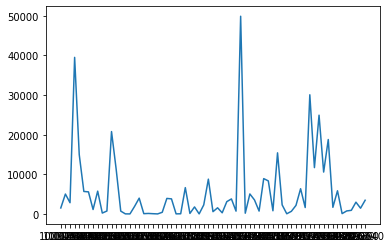

In [9]:
plt.plot(df_all.groupby('appid').count()['text'])

## filtering

In [10]:
# 출시후 30일까지 댓글만 남기기
df_all['after30days'] = pd.DatetimeIndex(df_all['first_date']) + pd.DateOffset(30)
df_all = df_all[df_all['publishedAt']<=df_all['after30days']]

In [11]:
# likeCount 1개 이상인 경우만 필터링
# df_all = df_all[df_all['likeCount'] > 1]

In [12]:
# outlier
# 732690 : FIVE NIGHTS AT FREDDYS VR HELP WANTED
df_all = df_all.drop(df_all[df_all['appid']=='732690'].index)

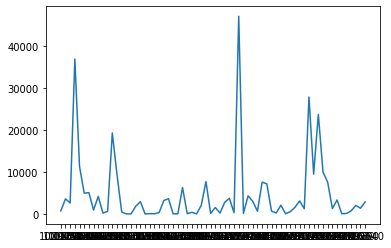

In [13]:
plt.plot(df_all.groupby('appid').count()['text'])

### split data

In [14]:
# 성공/보통 기준은 동접자 1000명
df_success = df_all[df_all['avg_player_count'] > 1000]
df_fail = df_all[df_all['avg_player_count'] < 1000]

In [15]:
success_game_list = df_success['gameName'].unique()
fail_game_list = df_fail['gameName'].unique()

### 텍스트 합치기

In [16]:
df_games = {}

In [17]:
text_all = {}
for gameName in df_all.gameName.unique():
    raw = df_all[df_all['gameName']==gameName]['text'].tolist()
    text = ' '.join([clean_text(t) for t in raw])
    text_all[gameName] = text

In [18]:
stw = stopwords.words('english')
token_all = {}
for key, val in text_all.items():
    tok = nltk.word_tokenize(val)
    token_all[key] = [w for w in tok if not w in stw]

In [19]:
token_cnt_all = {}
for key, val in token_all.items():
    token_cnt_all[key] = {k: v for k, v in sorted(Counter(token_all[key]).items(), key=lambda item: item[1], reverse=True)}

## tokenizing

In [20]:
raw_text_success = df_success['text'].tolist()

In [21]:
text_success = ' '.join([clean_text(t) for t in raw_text_success])

In [22]:
raw_text_fail = df_fail['text'].tolist()

In [23]:
text_fail = ' '.join([clean_text(t) for t in raw_text_fail])

### remove stopwords

In [24]:
stw = stopwords.words('english')

token_success = nltk.word_tokenize(text_success)
token_success = [w for w in token_success if not w in stw]

token_fail = nltk.word_tokenize(text_fail)
token_fail = [w for w in token_fail if not w in stw]

In [25]:
token_cnt_success = {k: v for k, v in sorted(Counter(token_success).items(), key=lambda item: item[1], reverse=True)}
token_cnt_fail = {k: v for k, v in sorted(Counter(token_fail).items(), key=lambda item: item[1], reverse=True)}

## entropy

In [26]:
word_list = list(set().union(token_cnt_success.keys(), token_cnt_fail.keys()))

In [27]:
def token2entropy(word: str, token_a: Dict, token_b):
    cnt_a, cnt_b = token_a.get(word,0), token_b.get(word,0)
    ent = entropy([cnt_a, cnt_b], base=2)
    return cnt_a, cnt_b, ent

In [28]:
def token2count(word, token_cnt, verbose=True, game_list=None):
    """
    game_list = {"success_game_list": success_game_list,
                 "fail_game_list": fail_game_list}
    """
    games_cnt = 0
    success_cnt =0
    fail_cnt =0
    
    for key, val in token_cnt.items():
        if word in val:
            if verbose:
                print(key, val[word])
            if game_list:
                if key in game_list['success_game_list']:
                    success_cnt+=1
                if key in game_list['fail_game_list']:
                    fail_cnt +=1
            games_cnt+=1
    return games_cnt, success_cnt, fail_cnt

In [29]:
entropy_list = {}
game_list = {
    "success_game_list":success_game_list,
    "fail_game_list":fail_game_list
}
for word in word_list:
    s = token_cnt_success.get(word, 0)
    f = token_cnt_fail.get(word, 0)
    tg, sg, fg = token2count(word, token_cnt_all, verbose=False, game_list=game_list)
    
    # 최소 성공게임 5개에 출현한 단어만 저장
    if sg >= 5:
    # if s >0 and f>0:
        if entropy([s, f], base=2) > 0.0:
            side = "success" if s > f else "fail"
            entropy_list[word] = (entropy([s, f], base=2), side, (s,f), (tg,sg,fg))

## entropy 순서로 word 정렬

In [30]:
{k: v for k, v in sorted(entropy_list.items(), key=lambda item: item[1], reverse=False)}

{'yakuza': (0.04001097736087626, 'success', (2083, 9), (9, 5, 4)),
 'layers': (0.062302547120773724, 'fail', (9, 1224), (17, 5, 12)),
 'lords': (0.07952810681713668, 'success', (1716, 17), (13, 6, 7)),
 'nico': (0.08865789440935096, 'success', (971, 11), (14, 7, 7)),
 'rtx': (0.10199477974775174, 'fail', (27, 2002), (13, 6, 7)),
 'ac': (0.11121644419957658, 'fail', (54, 3592), (18, 8, 10)),
 'conan': (0.1185023534677552, 'fail', (5, 307), (12, 5, 7)),
 'rage': (0.11904397818297308, 'success', (6532, 107), (28, 8, 20)),
 'creed': (0.12102345797781514, 'fail', (93, 5560), (20, 7, 13)),
 'borderlands': (0.12759401358168265, 'success', (2851, 51), (18, 8, 10)),
 'tracing': (0.13222665414785972, 'fail', (12, 641), (10, 5, 5)),
 'horror': (0.14961056394349884, 'fail', (38, 1732), (25, 6, 19)),
 'bethesda': (0.15272258995806035, 'success', (1864, 42), (12, 5, 7)),
 'flag': (0.15568430423248056, 'fail', (38, 1645), (22, 7, 15)),
 'critics': (0.1623261801753929, 'success', (82, 2), (7, 5, 2)),


In [31]:
# 개별 단어의 엔트로피 계산
token2entropy("critics", token_cnt_success, token_cnt_fail)

(82, 2, 0.1623261801753929)

In [32]:
# 개별 단어가 어떤 게임에 몇번 등장하였는지 return (전체게임개수, 성공게임개수, 보통게임개수)
token2count("critics", token_cnt_all, verbose=True, game_list=game_list)

Anno 1800 1
Yakuza Kiwami 2 2
Blood Fresh Supply 1
RAGE 2 22
Layers of Fear 2 1
OCTOPATH TRAVELER 56
Dota Underlords 1


(7, 5, 2)